In [317]:
from d2l import torch as d2l
import os
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn

devices = d2l.try_all_gpus()

In [318]:
def read_dataset(is_big_computer = False):
    names = ['user_id', 'movie_id', 'rating', 'timestamp']
    data = pd.read_csv("./ml-32m/ratings.csv", names=names, header=0)
    if not is_big_computer:
        data = data.sample(n=1_000_000, random_state=42) # Limit to 1 million ratings for faster processing
    data["user_id"] = data["user_id"]
    data["movie_id"] = data["movie_id"]
    num_users = data.user_id.unique().shape[0]
    num_movies = data.movie_id.unique().shape[0]
    return data, num_users, num_movies

def reindex_data(data : pd.DataFrame):
    user_id_map = {id: i for i, id in enumerate(data.user_id.unique())}
    movie_id_map = {id: i for i, id in enumerate(data.movie_id.unique())}
    
    data['user_id'] = data['user_id'].map(user_id_map)
    data['movie_id'] = data['movie_id'].map(movie_id_map)
    
    return data, num_users, num_movies

In [227]:
data, num_users, num_movies = read_dataset()

In [71]:
sparsity = 1 - len(data) / (num_users * num_movies)
print(f'number of users: {num_users}, number of movies: {num_movies}')
print(f'matrix sparsity: {sparsity:f}')

number of users: 167266, number of movies: 27726
matrix sparsity: 0.999784


In [72]:
data[:5]

,user_id,movie_id,rating,timestamp
10685861,66954,781,5.0,850944577
1552723,9877,574,4.0,945495614
6145184,38348,1088,2.0,999974867
16268584,101952,2706,1.0,1203077565
22418634,140400,275079,3.5,1653782463


In [73]:
data.describe()

,user_id,movie_id,rating,timestamp
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,100339.282490,29349.124476,3.539737,1.275225e+09
std,57917.799297,51012.984959,1.059928,2.561240e+08
min,1.000000,1.000000,0.500000,8.231852e+08
25%,50154.750000,1230.000000,3.000000,1.051545e+09
50%,100311.000000,3452.000000,3.500000,1.272615e+09
75%,150499.000000,44199.000000,4.000000,1.503010e+09
max,200948.000000,292755.000000,5.000000,1.697164e+09


## Plot the distribution of the ratings

Text(0, 0.5, 'Count')

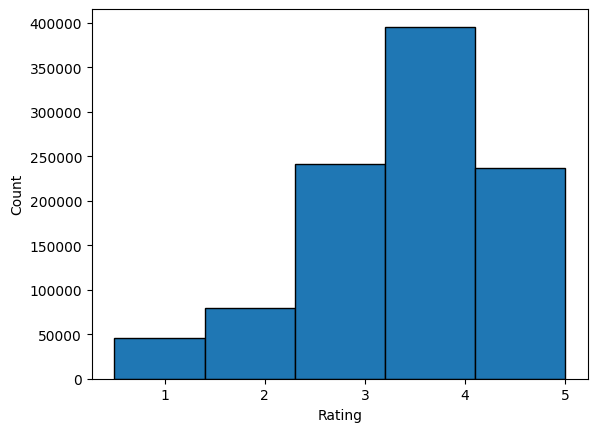

In [74]:
plt.hist(data["rating"], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')

## Splitting the dataset
We split the dataset into training and test sets. The following function provides two split modes including `random` and `seq-aware`. In the `random` mode, the function splits the 100k interactions randomly without considering timestamp and uses the 90% of the data as training samples and the rest 10% as test samples by default. In the `seq-aware` mode, we leave out the movie that a user rated most recently for test, and users’ historical interactions as training set. User historical interactions are sorted from oldest to newest based on timestamp. This mode will be used in the sequence-aware recommendation section.

In [263]:
def split_data(data : pd.DataFrame, num_users, num_movies, split_mode = "random", test_ratio=0.2):
    if split_mode == "random":
        training_mask = np.random.rand(len(data)) > test_ratio
        train_data = data[training_mask]
        test_data = data[~training_mask]
    
    elif split_mode == "seq-aware":
        user_groups = data.groupby('user_id')
        train_data = []
        test_data = []
        for _, group in user_groups:
            group = group.sort_values(by='timestamp', ascending=True)
            split_index = int(len(group) * (1 - test_ratio))
            train_data.append(group.iloc[:split_index])
            test_data.append(group.iloc[split_index:])
        train_data = pd.DataFrame(pd.concat(train_data, ignore_index=True))
        test_data = pd.DataFrame(pd.concat(test_data, ignore_index=True))
    
    else:
        raise ValueError("split_mode must be 'random' or 'seq-aware'")

    return train_data, test_data

## Loading the dataset

In [293]:
def load_data(data : pd.DataFrame, num_users, num_movies, feedback="explicit"):
    """
    returns lists of users, movies, ratings and a dictionary/matrix that records the interactions. 
    If feedback is "explicit", ratings are used as feedback.
    If feedback is "implicit", then the user didn't give any rating, so the user's action of interacting with the movie is considered as positive feedback.
    The `inter` is the interaction matrix that reflects this.
    """
    users, movies, scores = [], [], []
    inter = np.zeros((num_movies, num_users)) if feedback == 'explicit' else {}

    for line in data.itertuples(): # itertuples is faster than iterrows for large DataFrames
        user_id, movie_id = int(line.user_id), int(line.movie_id)
        score = int(line[3]) if feedback == "explicit" else 1
        users.append(user_id)
        movies.append(movie_id)
        scores.append(score)
        if feedback == "explicit":
            inter[movie_id - 1, user_id - 1] = score
        else:
            inter.setdefault(user_id - 1, []).append(movie_id - 1)
        
    return users, movies, scores, inter


In [294]:
def split_and_load_data(split_mode = "seq-aware", feedback="explicit", test_ratio = 0.1, batch_size = 256):
    data, num_users, num_movies = read_dataset()
    data, num_users, num_movies = reindex_data(data)
    train_data, test_data = split_data(data, num_users, num_movies, split_mode=split_mode, test_ratio=test_ratio)

    train_users, train_movies, train_scores, train_inter = load_data(train_data, num_users, num_movies, feedback=feedback)
    test_users, test_movies, test_scores, test_inter = load_data(test_data, num_users, num_movies, feedback=feedback)

    train_u = torch.tensor(np.array(train_users))
    train_m = torch.tensor(np.array(train_movies))
    train_r = torch.tensor(np.array(train_scores), dtype=torch.float32)
    test_u = torch.tensor(np.array(test_users))
    test_m = torch.tensor(np.array(test_movies))
    test_r = torch.tensor(np.array(test_scores), dtype=torch.float32)

    train_set = torch.utils.data.TensorDataset(train_u, train_m, train_r)
    test_set = torch.utils.data.TensorDataset(test_u, test_m, test_r)

    train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return num_users, num_movies, train_iter, test_iter




In [295]:
num_users, num_movies, train_iter, test_iter = split_and_load_data(
    test_ratio=0.1, batch_size=256)

## Matrix Factorization

Let $\mathbf{R} \in \mathbb{R}^{m \times n}$ denote the interaction matrix with $m$ users and $n$ items, and the testues of $\mathbf{R}$ represent explicit ratings. The user-item interaction will be factorized into a user latent matrix $\mathbf{P} \in \mathbb{R}^{m \times k}$ and an item latent matrix $\mathbf{Q} \in \mathbb{R}^{n \times k}$, where $k \ll m, n$, is the latent factor size. 

Let $\mathbf{p}_u$ denote the $u^{th}$ row of $\mathbf{P}$ and $\mathbf{q}_i$ denote the $i^{th}$ row of $\mathbf{Q}$. For a given item $i$, the elements of $\mathbf{q}_i$ measure the extent to which the item possesses those characteristics such as the genres and languages of a movie. For a given user $u$, the elements of $\mathbf{p}_u$ measure the extent of interest the user has in items' corresponding characteristics. These latent factors might measure obvious dimensions as mentioned in those examples or are completely uninterpretable. The predicted ratings can be estimated by
$$ \hat{\mathbf{R}} = \mathbf{P} \mathbf{Q}^{\top} $$
where $\hat{\mathbf{R}} \in \mathbb{R}^{m \times n}$ is the predicted rating matrix which has the same shape as $\mathbf{R}$. One major problem of this prediction rule is that users/items biases can not be modeled. For example, some users tend to give higher ratings or some items always get lower ratings due to poorer quality. These biases are commonplace in real-world applications. To capture these biases, user specific and item specific bias terms are introduced. Specifically, the predicted rating user $u$ gives to item $i$ is calculated by
$$ \hat{R}_{ui} = \mathbf{p}_u \mathbf{q}_i^{\top} + b_u + b_i $$
Then, we train the matrix factorization model by minimizing the mean squared error between predicted rating scores and real rating scores. The objective function is defined as follows:
$$ \underset{\mathbf{P}, \mathbf{Q}, b}{\text{argmin}} \sum_{(u,i) \in \mathcal{K}} \| R_{ui} - \hat{R}_{ui} \|^2 + \lambda (\|\mathbf{P}\|_F^2 + \|\mathbf{Q}\|_F^2 + b_u^2 + b_i^2) $$
where $\lambda$ denotes the regularization rate. The regularizing term $\lambda (\|\mathbf{P}\|_F^2 + \|\mathbf{Q}\|_F^2 + b_u^2 + b_i^2)$ is used to avoid over-fitting by penalizing the magnitude of the parameters. The $(u,i)$ pairs for which $R_{ui}$ is known are stored in the set $\mathcal{K} = \{(u,i) \mid R_{ui} \text{ is known}\}$. The model parameters can be learned with an optimization algorithm, such as Stochastic Gradient Descent and Adam.

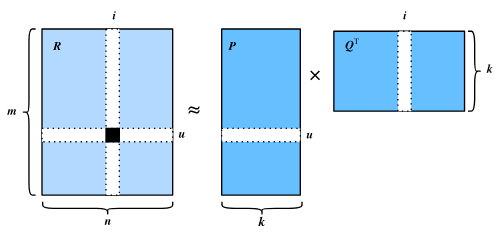

In [ ]:
class MF(d2l.Module):
    def __init__(self, num_latent, num_users, num_movies, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_latent)
        self.Q = nn.Embedding(num_movies, num_latent)
        self.num_latent = num_latent
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)

    def forward(self, user_id, movie_id):
        """
        user_id and movie_id should be tensors of shape (batch_size,).
        This function computes a pairwise dot product between each user and movie pair in the batch.
        Returns a tensor of shape (batch_size, 1) containing the predicted ratings for each pair.
        """
        if user_id.shape != movie_id.shape:
            raise testueError("user_id and movie_id must have the same shape.")        
    
        # if this is a single scalar tensor, add a dimension to make it a batch of size 1
        if user_id.ndim == 0: 
            user_id = user_id.unsqueeze(0)
        if movie_id.ndim == 0:
            movie_id = movie_id.unsqueeze(0)

        P_u = self.P(user_id)
        Q_m = self.Q(movie_id)
        user_bias = self.user_bias(user_id)
        movie_bias = self.movie_bias(movie_id)
        outputs = torch.sum(P_u * Q_m, dim = 1, keepdim=True) + user_bias + movie_bias
        return outputs


In [290]:
mf = MF(32, num_users, num_movies)
mf(torch.tensor([0, 1, 2]), torch.tensor([0, 1, 2])).shape

torch.Size([3, 1])

### Evaluator - difference between predicted and real rating scores

In [299]:
def evaluator(net, test_iter, devices=None):
    """
    Compute the RMSE of the model `net` on the test set `test_iter`
    `test_iter` generally consists of batches of (batch_size, 1, 1, 1) tuples. Each tuple is (user_id, movie_id, rating), where `rating` is the ground truth rating.
    """
    mse = nn.MSELoss() # torch doesn't have a built-in RMSE loss, so we use MSE and compute RMSE from it
    rmse = lambda y_hat, y: torch.sqrt(mse(y_hat, y))
    rmse_list = []

    # Wrap the model with DataParallel if multiple GPUs are available
    # Then, move the base model (or DataParallel wrapper) to the primary device as the parallelized module must 
    # have its parameters and buffers on device_ids[0] before running this DataParallel module.
    # https://docs.pytorch.org/docs/stable/generated/torch.nn.DataParallel.html
    if devices:
        net.to(devices[0])
        if len(devices) > 1:
            net = nn.DataParallel(net, device_ids=devices)
            print(f"Model wrapped with DataParallel on {len(devices)} GPUs.")    

    for idx, (users, movies, ratings) in enumerate(test_iter):
        users = users.to(devices[0] if devices else torch.device("cpu"))
        movies = movies.to(devices[0] if devices else torch.device("cpu"))
        ratings = ratings.to(devices[0] if devices else torch.device("cpu"))    
        outputs = net(users, movies).squeeze(1)
        rmse_list.append(rmse(outputs, ratings).item())
    return np.mean(np.array(rmse_list))

In [300]:
mf = MF(32, num_users, num_movies)
evaluator(mf, test_iter, devices)

6.8632526263466955

### Training and Etestuating the model

In [304]:
class Trainer(d2l.Trainer):
    def __init__(self, max_epochs, optimizer, loss, lr = 0.002, wd = 1e-5, num_gpus=torch.cuda.device_count(), gradient_clip_test=0):
        self.save_hyperparameters()
        super().__init__(max_epochs)
        self.train_losses = []
        self.test_losses = []
        self.optim = optimizer
        self.loss = loss
        self.devices = d2l.try_all_gpus() if num_gpus else [torch.device('cpu')]

    def prepare_model(self, model):
        """
        Configure the model for training, including wrapping it with DataParallel if multiple GPUs are available.
        This method is called implicitly by fit() before the training loop starts.

        Wrap the model with DataParallel if multiple GPUs are available.
        Then, move the base model (or DataParallel wrapper) to the primary device as the parallelized module must 
        have its parameters and buffers on device_ids[0] before running this DataParallel module.
        The data can be on any device, but the model must be on the primary device.
        https://docs.pytorch.org/docs/stable/generated/torch.nn.DataParallel.html  
        """
        self.model = model
      
        if self.devices:
            self.model.to(self.devices[0])
            if len(self.devices) > 1: 
                self.model = nn.DataParallel(self.model, device_ids=self.devices)
                print(f"Model wrapped with DataParallel on {len(self.devices)} GPUs.")
        self.model.to(self.devices[0])

    def prepare_data(self, train_iter, test_iter):
        self.train_dataloader = train_iter
        self.test_dataloader = test_iter
        self.num_train_batches = len(self.train_dataloader)
        self.num_test_batches = (len(self.test_dataloader)
                                if self.test_dataloader is not None else 0)

    def fit(self, model, train_iter, test_iter):
        self.animator = d2l.Animator(xlabel='epoch', xlim=[1, self.max_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])

        self.prepare_data(train_iter, test_iter)
        self.prepare_model(model)
        self.epoch = 0
        self.train_batch_idx = 0
        self.test_batch_idx = 0
        self.train_losses = []
        self.test_losses = []
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()    


    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optim.step()
                
            self.train_batch_idx += 1
            num_batches = len(self.train_dataloader)
            self.train_losses.append(loss.item())


        if self.test_dataloader is None:
            return

        self.model.eval()
        with torch.no_grad():
            loss = self.test_step()
            self.test_losses.append(loss)
            self.test_batch_idx += 1

        self.animator.add(self.epoch + 1, (self.train_losses[-1], self.test_losses[-1]))

    
    def training_step(self, batch):
        users, movies, ratings = batch
        outputs = self.model(users, movies).squeeze(1)
        loss = self.loss(outputs, ratings)
        return loss

    def test_step(self):
        return evaluator(self.model, self.test_dataloader, self.devices)

    def plot_losses(self):
        """Plot training and validation losses"""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        
        if self.test_losses:
            plt.plot(range(1, len(self.test_losses) + 1), self.test_losses, label='Validation Loss')
            
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.grid(True)
        
        # Clear the output to avoid multiple plots
        from IPython.display import clear_output
        clear_output(wait=True)
        plt.show()

        

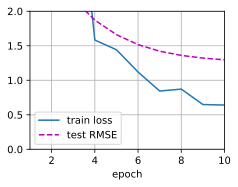

In [305]:
devices = d2l.try_all_gpus()
net = MF(32, num_users, num_movies)
lr = 0.002
wd = 1e-5
num_epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.MSELoss()
trainer = Trainer(max_epochs=num_epochs, optimizer=optimizer, loss=loss_fn, lr=lr, wd=wd, num_gpus=len(devices))
trainer.fit(net, train_iter, test_iter)

In [316]:
scores = net(torch.tensor([20], dtype=torch.int32, device=devices[0] if devices else torch.device('cpu')),
             torch.tensor([30], dtype=torch.int32, device=devices[0] if devices else torch.device('cpu')) 
             )
scores

tensor([[3.5494]], grad_fn=<AddBackward0>)